<center><h2>Assignment 06<br>
<b>Machine Learning to predict public sentiment from text data</b></h2></center><br>
Look into twitter text data to predict if the given text has positive or negative
sentiment towards a particular brand. The dataset includes twitter text related to
Apple and Google products with user sentiment ranked between ‘positive’,
‘negative’, ‘neutral’ and ‘no_idea’, sentiments. Create a simpleRNN or LSTM based
classifiers to classify tweets into the four classes. You can avoid
‘emotion_in_tweet_is_directed_at’ column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import string
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN

In [6]:
from keras.callbacks import EarlyStopping

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_csv('/content/drive/MyDrive/datasets/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

## Data Exploration

In [9]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [10]:
data = data.dropna(subset=['tweet_text'])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [12]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9092
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5388


In [13]:
print(data['is_there_an_emotion_directed_at_a_brand_or_product'].unique())

['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]


In [14]:
data['tweet_text'].values

array(['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
       "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
       '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
       ...,
       "Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",
       'Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.',
       '\x8cÏ¡\x8eÏà\x8aü_\x8b\x81Ê\x8b\x81Î\x8b\x81Ò\x8b\x81£\x8b\x81Á\x8bââ\x8b\x81_\x8b\x81£\x8b\x81\x8f\x8bâ_\x8bÛâRT @mention Google Tests \x89ÛÏCheck-in Offers\x89Û\x9d At #SXSW {link}'],
      dtype=object)

## Data Preprocessing

In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
wordnet_lem = WordNetLemmatizer()

In [17]:
def preprocess_text(text):
  # Remove punctuation and links
  punctuation_free = ''.join([i for i in text if i not in string.punctuation])
  no_links = re.sub(r'http\S+', '', punctuation_free)

  # Tokenization
  cleaned_text = re.sub('[^a-zA-Z\s]', '', no_links)
  tokens = word_tokenize(cleaned_text)

  # Remove stop words
  no_stop_words = [word for word in tokens if word.lower() not in stopwords.words('english')]

  # Lemmatization
  lemma = [wordnet_lem.lemmatize(word) for word in no_stop_words]

  # Convert to lowercase
  text_list = [item.lower() for item in lemma]

  return ' '.join(text_list)

In [18]:
data['preprocessed_tweet'] = data['tweet_text'].apply(preprocess_text)

In [19]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,preprocessed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley g iphone hr tweeting riseaustin dead ne...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw hope year festival isnt crashy year iphon...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri sxsw marissa mayer g...


## Spliting dataset into training and testing sets

In [20]:
x = data['preprocessed_tweet'].values
y = data['is_there_an_emotion_directed_at_a_brand_or_product'].values

In [21]:
le = LabelEncoder()
y = le.fit_transform(y)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Padding and tokenizing the preprocessed text

In [23]:
# Tokenize the text data
max_words = 10000
tokenizer = Tokenizer(num_words = max_words, oov_token='<OOV>')
'''Keras lets us define an Out Of Vocab token(OOV) -
this will replace any unknown words with a token of our choosing.
This is better than just throwing away unknown words since it tells our model there was information here.'''

tokenizer.fit_on_texts(x_train)

In [24]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [25]:
x_train_pad = pad_sequences(x_train_seq, maxlen=100)
x_test_pad = pad_sequences(x_test_seq, maxlen=100)

## Model creation

### LSTM

In [26]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=100, input_length=100))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(4, activation='softmax'))

In [27]:
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
checkpoint = EarlyStopping(patience=5)

In [29]:
epochs = 20
history = lstm_model.fit(x_train_pad, y_train, epochs = epochs, validation_split=0.1, callbacks = checkpoint)

Epoch 1/20
205/205 [==============================] - 31s 136ms/step - loss: 0.9571 - accuracy: 0.5818 - val_loss: 0.8599 - val_accuracy: 0.6415
Epoch 2/20
205/205 [==============================] - 24s 118ms/step - loss: 0.7806 - accuracy: 0.6706 - val_loss: 0.7852 - val_accuracy: 0.6538
Epoch 3/20
205/205 [==============================] - 27s 133ms/step - loss: 0.5481 - accuracy: 0.7934 - val_loss: 0.8344 - val_accuracy: 0.6648
Epoch 4/20
205/205 [==============================] - 27s 129ms/step - loss: 0.4034 - accuracy: 0.8463 - val_loss: 0.9243 - val_accuracy: 0.6648
Epoch 5/20
205/205 [==============================] - 27s 130ms/step - loss: 0.3263 - accuracy: 0.8759 - val_loss: 1.0968 - val_accuracy: 0.6236
Epoch 6/20
205/205 [==============================] - 26s 126ms/step - loss: 0.2788 - accuracy: 0.8911 - val_loss: 1.0318 - val_accuracy: 0.6648
Epoch 7/20
205/205 [==============================] - 26s 127ms/step - loss: 0.2400 - accuracy: 0.9008 - val_loss: 1.2173 - val_ac

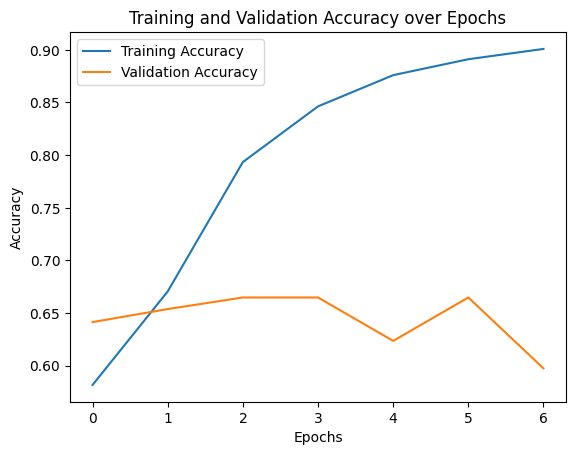

In [30]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

## RNN

In [31]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_words, output_dim=100, input_length=100))
rnn_model.add(SimpleRNN(100))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(20,activation='relu'))
rnn_model.add(Dense(4, activation='softmax'))

In [32]:
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
epochs = 20
history = rnn_model.fit(x_train_pad, y_train, epochs = epochs, validation_split=0.1, callbacks = checkpoint)

Epoch 1/20
205/205 [==============================] - 14s 57ms/step - loss: 0.9591 - accuracy: 0.5742 - val_loss: 0.8619 - val_accuracy: 0.6415
Epoch 2/20
205/205 [==============================] - 13s 65ms/step - loss: 0.7845 - accuracy: 0.6692 - val_loss: 0.8440 - val_accuracy: 0.6181
Epoch 3/20
205/205 [==============================] - 14s 67ms/step - loss: 0.4856 - accuracy: 0.8293 - val_loss: 0.9347 - val_accuracy: 0.6442
Epoch 4/20
205/205 [==============================] - 12s 59ms/step - loss: 0.3235 - accuracy: 0.8912 - val_loss: 1.0807 - val_accuracy: 0.5934
Epoch 5/20
205/205 [==============================] - 12s 58ms/step - loss: 0.2674 - accuracy: 0.9054 - val_loss: 1.1756 - val_accuracy: 0.6209
Epoch 6/20
205/205 [==============================] - 14s 67ms/step - loss: 0.2276 - accuracy: 0.9169 - val_loss: 1.1922 - val_accuracy: 0.5879
Epoch 7/20
205/205 [==============================] - 14s 68ms/step - loss: 0.1889 - accuracy: 0.9291 - val_loss: 1.3164 - val_accuracy:

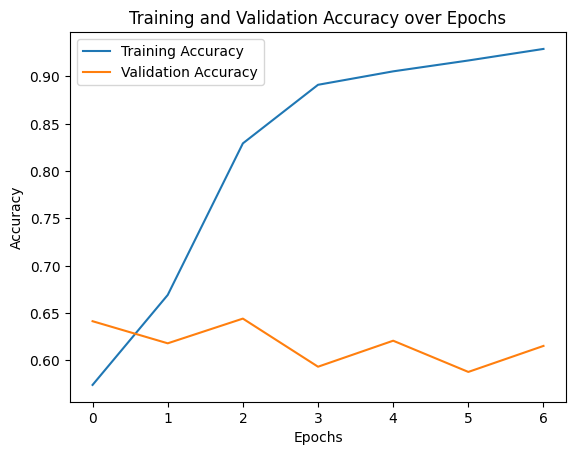

In [34]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Testing

In [35]:
results_lstm = lstm_model.evaluate(x_test_pad, y_test)
results_rnn = rnn_model.evaluate(x_test_pad, y_test)

57/57 [==============================] - 1s 13ms/step - loss: 1.3680 - accuracy: 0.5948


In [36]:
print('LSTM :')
print(f'Test Loss: {results_lstm[0]}')
print(f'Test Accuracy: {results_lstm[1]}')
print('\n\nRNN :')
print(f'Test Loss: {results_rnn[0]}')
print(f'Test Accuracy: {results_rnn[1]}')

LSTM :
Test Loss: 1.3117501735687256
Test Accuracy: 0.603628396987915


RNN :
Test Loss: 1.367977499961853
Test Accuracy: 0.5948323011398315


<b><i> Here the LSTM model has a higher test accuracy compared to the RNN model.

In [37]:
y_pred = lstm_model.predict(x_test_pad)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Decode labels using the LabelEncoder
y_test_labels = le.inverse_transform(y_test)
y_pred_labels_decoded = le.inverse_transform(y_pred_labels)

print(classification_report(y_test_labels, y_pred_labels_decoded))

57/57 [==============================] - 2s 26ms/step
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        27
                  Negative emotion       0.38      0.32      0.35       121
No emotion toward brand or product       0.72      0.63      0.68      1065
                  Positive emotion       0.50      0.63      0.56       606

                          accuracy                           0.60      1819
                         macro avg       0.40      0.40      0.40      1819
                      weighted avg       0.62      0.60      0.60      1819




*   <i>The highest precision and recall are observed for the class "No emotion toward brand or product.
*   The precision and recall for "Negative emotion" and "Positive emotion" are moderate.
*   The class "I can't tell" has low precision, recall, and F1-score, indicating challenges in predicting this class.

## Prediction on new data

In [38]:
def predict_sentiment(model, text):
    preprocessed_text = preprocess_text(text)

    # Tokenize and pad the preprocessed text
    sequences = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequences = pad_sequences(sequences, maxlen=100)

    # Make predictions
    predictions = model.predict(padded_sequences)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])

    # Decode the predicted class
    predicted_class = le.inverse_transform([predicted_class_index])[0]

    return predicted_class

In [40]:
text_to_predict = "I love the new iPhone!"
predicted_class_lstm = predict_sentiment(lstm_model, text_to_predict)
predicted_class_rnn= predict_sentiment(rnn_model, text_to_predict)

print(f"LSTM Predicted Sentiment as: {predicted_class_lstm}")
print(f"RNN Predicted Sentiment as: {predicted_class_rnn}")

1/1 [==============================] - 0s 495ms/step
LSTM Predicted Sentiment as: Positive emotion
RNN Predicted Sentiment as: Positive emotion


In [41]:
text_to_predict = "I am not sure I want it. It's too big to fit in my back pocket"
predicted_class_lstm = predict_sentiment(lstm_model, text_to_predict)
predicted_class_rnn= predict_sentiment(rnn_model, text_to_predict)

print(f"LSTM Predicted Sentiment as: {predicted_class_lstm}")
print(f"RNN Predicted Sentiment as: {predicted_class_rnn}")

1/1 [==============================] - 0s 65ms/step
LSTM Predicted Sentiment as: Positive emotion
RNN Predicted Sentiment as: No emotion toward brand or product


In [42]:
text_to_predict ='Had a terrible experience with my Android phone. Never buying from them again.'
predicted_class_lstm = predict_sentiment(lstm_model, text_to_predict)
predicted_class_rnn= predict_sentiment(rnn_model, text_to_predict)

print(f"LSTM Predicted Sentiment as: {predicted_class_lstm}")
print(f"RNN Predicted Sentiment as: {predicted_class_rnn}")

1/1 [==============================] - 0s 24ms/step
LSTM Predicted Sentiment as: Negative emotion
RNN Predicted Sentiment as: Negative emotion
